In [2]:
# Install the latest version of the Transformational Measures lib
#!pip install git+git://github.com/facundoq/transformational_measures.git
#!pip install torchvision

%load_ext autoreload
%autoreload 2


# Define a CNN model that implements ObservableLayersModule

In [23]:
import transformational_measures as tm
import torch
from torch import nn

# Class for PyTorch models that return intermediate results
from transformational_measures.pytorch import ObservableLayersModule

# Utility class, same as PyTorch Sequential but returns intermediate layer values
from transformational_measures.pytorch import SequentialWithIntermediates

class Flatten(nn.Module):
    def forward(self, input:torch.Tensor):
        return input.view(input.size(0), -1)
    
# Model definition
class CNN(ObservableLayersModule):
    def __init__(self,shape):
        super(CNN, self).__init__()
        self.shape=shape
        c,h,w=shape
        h_flat,w_flat=h//4,w//4
        filters=32
        filters2=filters*2
        flat=h_flat*w_flat*filters2
        self.model=SequentialWithIntermediates(
        nn.Conv2d(c, filters, 3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Conv2d(filters, filters2, 3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2),
        Flatten(),
        nn.Linear(flat, 128),
        nn.ReLU(),
        nn.Linear(128, 10),
        nn.LogSoftmax(dim=-1),
        )

    # forward works as normal
    def forward(self, x):
        return self.model.forward(x)

    # required by ObservableLayersModule
    def forward_intermediates(self,x):
        return self.model.forward_intermediates(x)
    
    # required by ObservableLayersModule
    # Taken care by SequentialWithIntermediates
    def activation_names(self):
        return self.model.activation_names()


    

# Usual train/fit test/evaluate methods

In [26]:
import torch.nn.functional as F
# train and test as usual
def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    batches=len(train_loader)
    log_interval_batches=int(batches*args.log_interval)
    #device=model.device()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval_batches == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            if args.dry_run:
                break


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))



# Train model for MNIST


In [28]:
from torchvision import datasets, transforms
import torch
from torch import optim
from torch.optim.lr_scheduler import StepLR

# CONFIG
class Options:
  def __init__(self,lr=0.1,gamma=0.7,epochs=1,save_model=False,
               seed=0,batch_size=256,test_batch_size=512,
               log_interval=0.2,dry_run=False):
    self.lr=lr
    self.gamma=gamma
    self.epochs=epochs
    self.save_model=save_model
    self.seed=seed
    self.batch_size=batch_size
    self.test_batch_size=test_batch_size
    self.log_interval=log_interval
    self.dry_run=dry_run

args=Options()
use_cuda = torch.cuda.is_available()
torch.manual_seed(args.seed)
device = torch.device("cuda" if use_cuda else "cpu")

# DATASET
base_preprocessing=[
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ]
# Rotation data augmentation
# CHANGE THIS VARIABLE from 0 to 180 to train with different intensities of data augmentation
# More data augmentation will cause the network to be more invariant
degree_range= 180 # train with random rotations from -degree_range to degree_range
train_augmentation=[transforms.RandomRotation(degree_range)]
train_transform=transforms.Compose(train_augmentation+base_preprocessing)
measure_transform=transforms.Compose(base_preprocessing)

dataset1 = datasets.MNIST('../data', train=True, download=True,
                    transform=train_transform)
dataset2 = datasets.MNIST('../data', train=False,
                    transform=train_transform) 
train_loader = torch.utils.data.DataLoader(dataset1,args.batch_size)
test_loader = torch.utils.data.DataLoader(dataset2,args.test_batch_size)



# TRAIN
model = CNN((1,28,28)).to(device)
print(f"Training network with device: {device}")
optimizer = optim.Adadelta(model.parameters(), lr=args.lr)

scheduler = StepLR(optimizer, step_size=1, gamma=args.gamma)
for epoch in range(1, args.epochs + 1):
    train(args, model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
    scheduler.step()

if args.save_model:
    torch.save(model.state_dict(), "mnist_cnn.pt")


Training network with device: cpu
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.313241
Train Epoch: 1 [12032/60000 (20%)]	Loss: 1.663875
Train Epoch: 1 [24064/60000 (40%)]	Loss: 1.426891
Train Epoch: 1 [36096/60000 (60%)]	Loss: 1.112256
Train Epoch: 1 [48128/60000 (80%)]	Loss: 0.988363

Test set: Average loss: 1.1301, Accuracy: 6021/10000 (60%)



# Measure model's invariance  to rotations



In [29]:
# Iterate over images from MNIST without labels
class NoLabelsMNIST(datasets.MNIST):
  def __getitem__(self, index):
    x,y=super().__getitem__(index)
    return x

dataset_nolabels = NoLabelsMNIST('../data', train=False, download=True,
                    transform=measure_transform)

# Create a set of rotation transformations
from transformational_measures.transformations.parameters import UniformRotation
from transformational_measures.transformations.pytorch.affine import AffineGenerator
rotation_parameters=UniformRotation(n=8,angles=360)
transformations=AffineGenerator(r=rotation_parameters)

# Define an iterator over activations for pytorch
iterator = tm.NormalPytorchActivationsIterator(model, dataset_nolabels, transformations, 
                                                batch_size=64,num_workers=1,use_cuda=use_cuda)

# evaluate NormalizedVariance measure, with the iterator
measure=tm.NormalizedVariance(tm.ConvAggregation.none)
measure_result = measure.eval(iterator)

# Save result
import pickle
result_filepath=f'rot{degree_range}_measure_result.pickle'
with open(result_filepath, 'wb') as f:
    pickle.dump(measure_result, f)

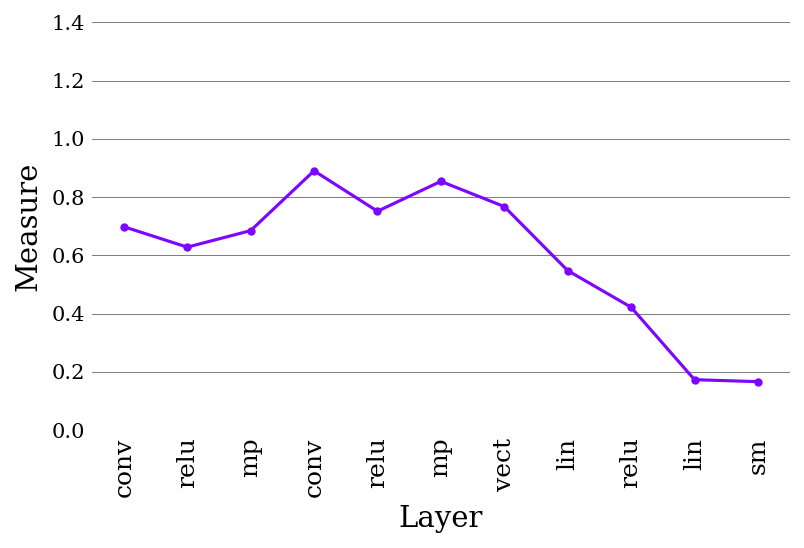

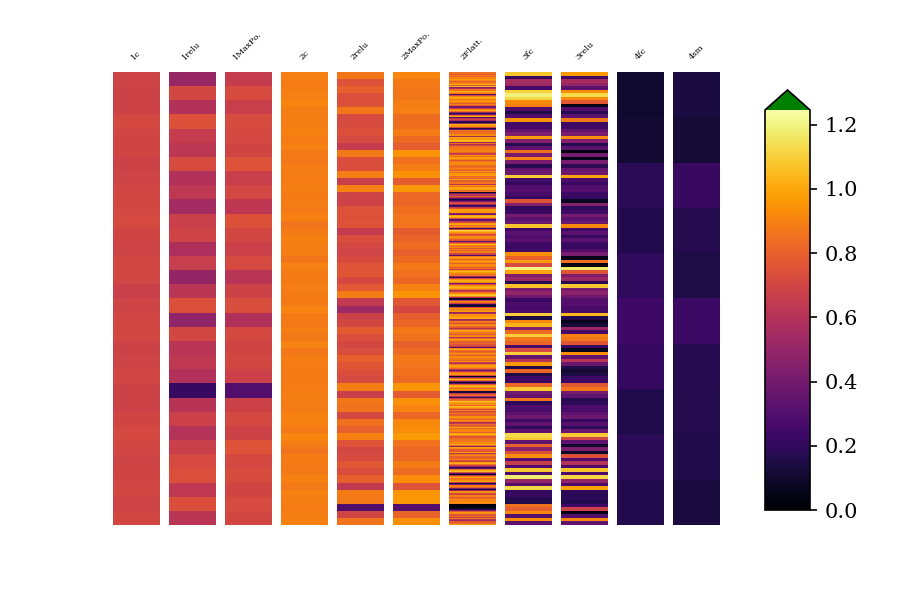

In [31]:
# Load result (optional, in case you don't want to run the above or your session died)
with open(result_filepath, 'rb') as f:
    measure_result=pickle.load(f)

from transformational_measures import visualization
results=[measure_result]
plot_filepath=f"rot{degree_range}_variance_by_layers.png"
visualization.plot_collapsing_layers_same_model(results, plot_filepath)
heatmap_filepath=f"rot{degree_range}_variance_heatmap.png"
visualization.plot_heatmap(measure_result,heatmap_filepath)
from IPython.display import Image,display
display(Image(filename=plot_filepath))
display(Image(filename=heatmap_filepath))
